# Example of adversarial training with FGSM

This notebook provides an example for using adversarial training with the FGSM attack on a LeNet model trained on MNIST dataset. The notebook also shows the effect of pruning (using unstructured pruning) on the adversarially trained model. 

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datetime import datetime 
#import models
from utils import train_classifier as tr
from dataloaders import mnist_loader
import copy
from attacks import fgsm
from models import lenet
from defenses import AdvTrainingFGSM
from pruning import UnstructuredPruning


# Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda:0" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


### Training the model

In [12]:
#Training hyperparamaeters
batch_size_tr = 64
batch_size_test = 64 
learning_rate = 0.00001
#Load training and test data
train_loader, test_loader = mnist_loader.get_loader(batch_size_tr, batch_size_test)


torch.manual_seed(1)
model = lenet.LeNet1c().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()
n_epochs = 100
PATH = "results/AdvTraining_leNetMNIST.pt"
epoch_evaluation = 2
epoch_save_checkpoint = 5
resumeTraining = False
epsilon = 0.2

In [13]:
print(device)
print("START TRAINING...")
model, optimizer = AdvTrainingFGSM.AdvTrainFGSM(model, loss, optimizer, train_loader, test_loader, n_epochs, epsilon,  
          device, epoch_evaluation, epoch_save_checkpoint, PATH, resumeTraining)

print("TRAINING FINISHED...")
acc = tr.get_accuracy(model, test_loader, device)
print(f'Test accuracy: {100 * acc:.3f}%')

cuda:0
START TRAINING...
Training epoch:  1
Training loss: 0.0361
 ---------------------------------------- [  1.00%]
Training epoch:  2
Training loss: 0.0356
TRAINING ACCURACY: 50.0433%
TEST ACCURACY: 51.0600%
 #--------------------------------------- [  2.00%]
Training epoch:  3
Training loss: 0.0340
 #--------------------------------------- [  3.00%]
Training epoch:  4
Training loss: 0.0319
TRAINING ACCURACY: 64.6733%
TEST ACCURACY: 66.2200%
 ##-------------------------------------- [  4.00%]
Training epoch:  5
Training loss: 0.0302

-->Saving model as  results/AdvTraining_leNetMNIST.pt 

 ##-------------------------------------- [  5.00%]
Training epoch:  6
Training loss: 0.0289
TRAINING ACCURACY: 72.7933%
TEST ACCURACY: 73.8100%
 ##-------------------------------------- [  6.00%]
Training epoch:  7
Training loss: 0.0278
 ###------------------------------------- [  7.00%]
Training epoch:  8
Training loss: 0.0267
TRAINING ACCURACY: 77.6950%
TEST ACCURACY: 78.9300%
 ###--------------

Training epoch:  64
Training loss: 0.0112
TRAINING ACCURACY: 96.0550%
TEST ACCURACY: 96.4100%
 ##########################-------------- [ 64.00%]
Training epoch:  65
Training loss: 0.0111

-->Saving model as  results/AdvTraining_leNetMNIST.pt 

 ##########################-------------- [ 65.00%]
Training epoch:  66
Training loss: 0.0110
TRAINING ACCURACY: 96.0867%
TEST ACCURACY: 96.4500%
 ##########################-------------- [ 66.00%]
Training epoch:  67
Training loss: 0.0110
 ###########################------------- [ 67.00%]
Training epoch:  68
Training loss: 0.0109
TRAINING ACCURACY: 96.1417%
TEST ACCURACY: 96.4800%
 ###########################------------- [ 68.00%]
Training epoch:  69
Training loss: 0.0108
 ############################------------ [ 69.00%]
Training epoch:  70
Training loss: 0.0107
TRAINING ACCURACY: 96.2633%
TEST ACCURACY: 96.6000%

-->Saving model as  results/AdvTraining_leNetMNIST.pt 

 ############################------------ [ 70.00%]
Training epoch:  71


### Parameters for the experiment

In [14]:
#Percentage of pruning percentages to explore
perc = [0, 0.2, 0.4, 0.6]
#Values of epsilon used for the FGSM attack
epsilon = [0, 0.1, 0.2, 0.3]

#Placeholder to store the robust accuracy for different levels of pruning and attack strength
accuracies = torch.zeros((len(perc), len(epsilon)))

### Computing the clean accuracy

In [15]:
#First, we compute the clean accuracy (when there is no attack) for models with different amount of pruning
print("----------------------------------")
print("CLEAN ACCURACY")
print("----------------------------------")
#Clean accuracy for the model without pruning
print("PRUNING PERCENTAGE: 0%")
print("Accuracy after pruning: ")
acc_pruned = tr.get_accuracy(model, test_loader, device)
accuracies[0][0] = acc_pruned.cpu()
print(f'Test accuracy: {100 * acc_pruned:.3f}%')
#Clean accuracy of the pruned models
for i in range(len(perc)):
    if perc[i] == 0: continue 
    #Copy the original model before pruning
    model_pruned = copy.deepcopy(model).to(device)
    #Apply structured pruning
    UnstructuredPruning.UnstructuredPruning(model_pruned, perc[i])
    print("PRUNING PERCENTAGE: ", 100*perc[i], "%")
    acc_pruned = tr.get_accuracy(model_pruned, test_loader, device)
    accuracies[i][0] = acc_pruned.cpu()
    print(f'Test accuracy: {100 * acc_pruned:.3f}%')

----------------------------------
CLEAN ACCURACY
----------------------------------
PRUNING PERCENTAGE: 0%
Accuracy after pruning: 
Test accuracy: 97.180%
PRUNING PERCENTAGE:  20.0 %
Test accuracy: 97.030%
PRUNING PERCENTAGE:  40.0 %
Test accuracy: 95.280%
PRUNING PERCENTAGE:  60.0 %
Test accuracy: 88.320%


### Computing the robust accuracy

In [16]:
#Set the attack type to untargeted
attack_type = 'untargeted'

print("----------------------------------")
print("FGSM Attack")
print("----------------------------------")

# Run the attack on the whole test set for different values of epislon
for i in range(len(epsilon)):
    
    if epsilon[i] == 0: continue
    # Run the attack for models with different amount of pruning
    print("\nEPSILON: ", epsilon[i])
    for j in range(len(perc)):
        if perc[j] == 0:
            acc, _ = fgsm.test(model, device, test_loader, epsilon[i], attack_type)
            accuracies[j][i] = acc
            print(f"Non-pruned model - Test Accuracy = {100*acc:.3f}%")
        else:
            model_pruned = copy.deepcopy(model).to(device)
            UnstructuredPruning.UnstructuredPruning(model_pruned, perc[j])
            print("PRUNING PERCENTAGE: ", 100*perc[j], "%")
            acc, _ = fgsm.test(model_pruned, device, test_loader, epsilon[i], attack_type)
            accuracies[j][i] = acc
            print(f"Test Accuracy = {100*acc:.3f}%")

----------------------------------
FGSM Attack
----------------------------------

EPSILON:  0.1
Non-pruned model - Test Accuracy = 92.100%
PRUNING PERCENTAGE:  20.0 %
Test Accuracy = 91.730%
PRUNING PERCENTAGE:  40.0 %
Test Accuracy = 86.350%
PRUNING PERCENTAGE:  60.0 %
Test Accuracy = 77.670%

EPSILON:  0.2
Non-pruned model - Test Accuracy = 80.910%
PRUNING PERCENTAGE:  20.0 %
Test Accuracy = 80.500%
PRUNING PERCENTAGE:  40.0 %
Test Accuracy = 71.200%
PRUNING PERCENTAGE:  60.0 %
Test Accuracy = 64.350%

EPSILON:  0.3
Non-pruned model - Test Accuracy = 54.220%
PRUNING PERCENTAGE:  20.0 %
Test Accuracy = 52.540%
PRUNING PERCENTAGE:  40.0 %
Test Accuracy = 43.930%
PRUNING PERCENTAGE:  60.0 %
Test Accuracy = 41.620%


### Plot the results

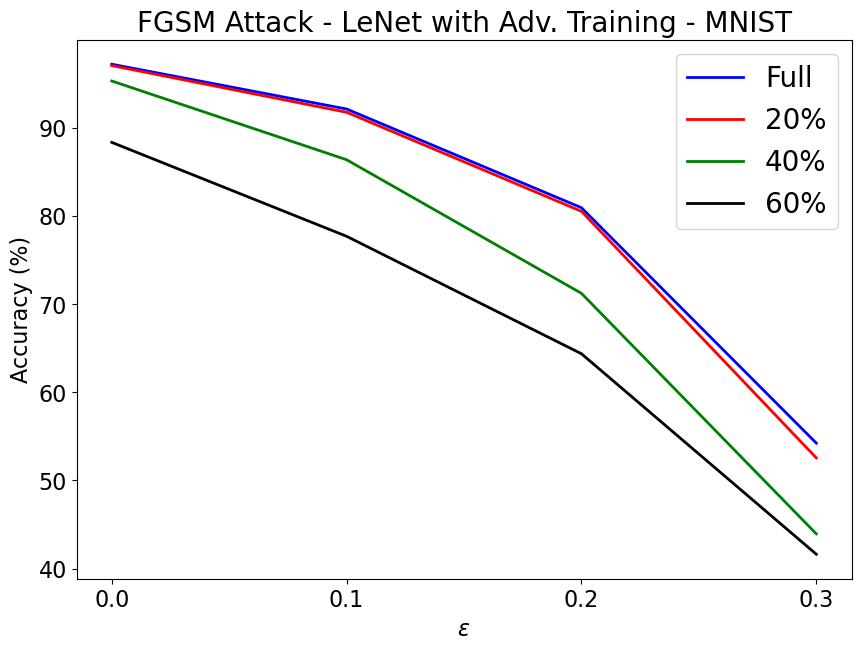

In [18]:
eps = np.array(epsilon)
accs = np.array(accuracies)*100
plt.figure(figsize=(10,7))
plt.plot(eps, accs[0,:],'b', linewidth=2)
plt.plot(eps, accs[1,:], 'r', linewidth=2)
plt.plot(eps, accs[2,:], 'g', linewidth=2)
plt.plot(eps, accs[3,:], 'k', linewidth=2)
plt.xlabel('$\epsilon$',fontsize=16)
plt.ylabel('Accuracy (%)',fontsize=16)
plt.legend(('Full', '20%', '40%', '60%'), fontsize=20)
plt.title('FGSM Attack - LeNet with Adv. Training - MNIST',fontsize=20)
plt.yticks(fontsize=16)
plt.xticks([0, 0.1, 0.2, 0.3], fontsize=16)
plt.show()